# Finite Elements Coursework

In [2]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

## Problem setup

Consider a two dimensional solid body modelled by a linear, isotropic material (as in lab 2). We will use a model for concrete with Young's modulus $E = 40$GPa, Poisson's ratio $\nu = 0.15$, and density $2400$kg m${}^{-2}$ (obviously the density should really be per volume; here we factor out the $y$ direction, assuming everything is symmetric and $1$m long in that direction).

The body will be a stylized "N" shape: assuming the bottom left corner is at the origin of the coordinates, the body will be $3$m high and $4$m wide.

In [3]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np
from numba import jit
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12, 6)

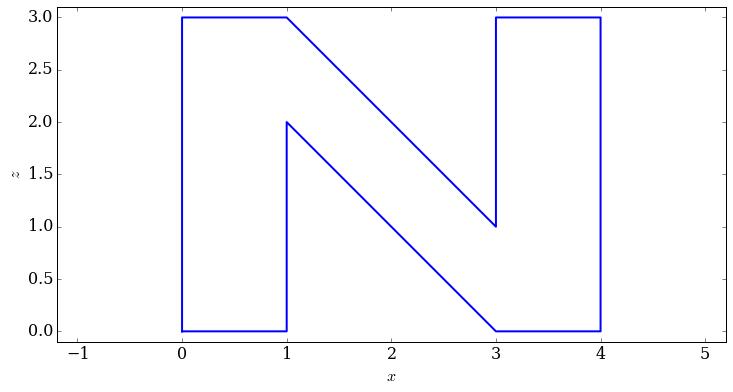

In [4]:
corners = np.array([[0,0],[0,3],[1,3],[3,1],[3,3],[4,3],[4,0],[3,0],[1,2],[1,0],[0,0]])
pyplot.plot(corners[:,0],corners[:,1],linewidth=2)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$z$")
pyplot.axis('equal')
pyplot.ylim(-0.1,3.1);

Set the displacements along the $y=0$ boundary to be zero. All other boundaries are free. Write a finite element method using **triangular** elements to compute the displacement of the body satisfying the equation

$$
  \nabla \sigma + {\bf b} = {\bf 0}
$$

where the body force is given by gravity, ${\bf b} = (0, -m g)^T$ where $g = 9.8$m s${}^{-2}$ and $m$ is the mass of the block, $m = 12000$kg.

First use the obvious sixteen elements with triangles one metre to a side. Then split each element into two triangles that are half a metre to a side.

The standard triangle in $(\xi, \eta)$ coordinates is:

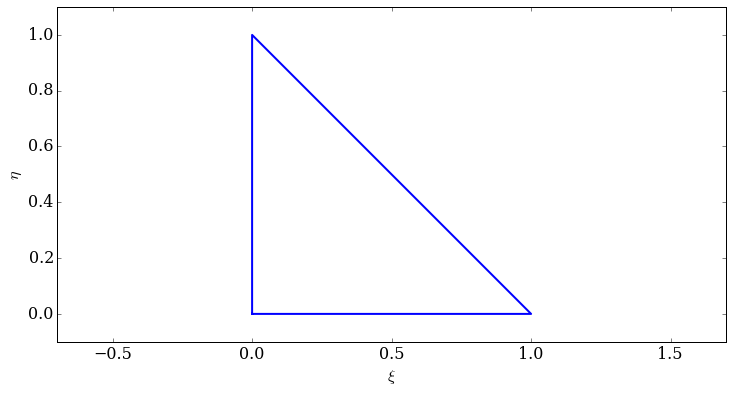

In [5]:
corners = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [0.0, 0.0]])
pyplot.plot(corners[:,0],corners[:,1],linewidth=2)
pyplot.xlabel(r"$\xi$")
pyplot.ylabel(r"$\eta$")
pyplot.axis('equal')
pyplot.ylim(-0.1,1.1);

The shape functions for a triangle are

\begin{align}
  N_1(\xi, \eta) &= 1 - \eta - \xi, \\
  N_2(\xi, \eta) &= \eta, \\
  N_3(\xi, \eta) &= \xi.
\end{align}

In [6]:
def deriv_shape_functions():
    """
    Value of the derivatives of the shape functions wrt parametric coordinates at given parametric coordinates
    
    Returns
    -------
    
    d_N_i : array of float
        The three shape functions derivatives wrt (xi, eta)
    """
    dN = np.zeros((2,3))
    dN[0,0] = -1.0
    dN[0,1] = 0.0
    dN[0,2] = 1.0
    dN[1,0] = -1.0
    dN[1,1] = 1.0
    dN[1,2] = 0.0
    
    return dN

The two-point Gauss quadrature formula within the standard triangular element is

\begin{equation}
  \int \text{d} \xi \, \text{d} \eta \, f(\eta, \xi) = \frac{1}{6} \left[ f \left( \frac{1}{6}, \frac{1}{6} \right) +  f \left( \frac{2}{3}, \frac{1}{6} \right) +  f \left( \frac{1}{6}, \frac{2}{3} \right) \right].
\end{equation}

In [7]:
def Jacobian(node_coords):
    """
    Jacobian matrix at given parametric coordinates
    
    Parameters
    ----------
    
    coords : vector of float
        Parametric coordinates (xi, eta)
    node_coords : array of float
        Physical coordinates of the nodes defining this element
    
    Returns
    -------
    
    J : array of float
        The Jacobian (d{x,y} / d{xi,eta})
    """
    
    dN = deriv_shape_functions()
    J = np.dot(dN, node_coords)
    return J

In [8]:
def GaussTri_Volume(field, node_coords):
    """
    Use two point Gauss quadrature to evaluate the integral of a field over an element
    
    Parameters
    ----------
    
    field : function
        A way of evaluating the field variable at given parametric coordinates within the element.
    node_coords : array of float
        Physical coordinates of the nodes defining this element
    
    Returns
    -------
    
    I : float
        The integral over the element
    """
    
    point1 = 1/float(6)
    point2 = 2/float(3)
    I = 0
    I += np.linalg.det(Jacobian(node_coords))*field([point1, point1])
    I += np.linalg.det(Jacobian(node_coords))*field([point2, point1])
    I += np.linalg.det(Jacobian(node_coords))*field([point1, point2])
    I /= 6.0
    return I

In [9]:
def Bmatrix(node_coords):
    """
    Strain-displacement B matrix (dN/dx = J^{-1} dN/dxi) at given parametric coordinates
    
    Parameters
    ----------
    node_coords : array of float
        Physical coordinates of the nodes defining this element
    
    Returns
    -------
    
    B : array of float
        The Strain-displacement matrix 
    """
    
    dN = deriv_shape_functions()
    J = Jacobian(node_coords)
    B = np.dot(np.linalg.inv(J), dN)
    return B


In [10]:
def KD(i,j):
    """
    Kronecker delta
    """
    
    return int(i==j)

In [11]:
def generate_constituitive_relation(E, nu):
    """
    Return function giving the consituitive relation C_{ijkl}
    """
    
    lam = E * nu / (1.0 + nu) / (1.0 - 2.0 * nu)
    mu = E / 2.0 / (1.0 + nu)
    
    C = lambda i, j, k, l: lam*KD(i,j)*KD(k,l) + mu*(KD(i,k)*KD(j,l)+KD(i,l)*KD(j,k))

    return C

In [12]:
def stiffness_integrand(A, B, j, l, C, node_coords):
    """
    Return function giving the integrand for the stiffness matrix calculation
    """
    
    integrand = lambda coords :\
        C[0,j,0,l]*Bmatrix(node_coords)[0,A]*Bmatrix(node_coords)[0,B] + \
        C[1,j,0,l]*Bmatrix(node_coords)[1,A]*Bmatrix(node_coords)[0,B] + \
        C[0,j,1,l]*Bmatrix(node_coords)[0,A]*Bmatrix(node_coords)[1,B] + \
        C[1,j,1,l]*Bmatrix(node_coords)[1,A]*Bmatrix(node_coords)[1,B]
    
    return integrand

In [13]:
@jit
def element_stiffness(node_coords, C):
    """
    Compute the element stiffness matrix for a given element defined by its node locations
    """
    assert C.ndim == 4, "The C matrix must be 4-dimensional"
    K = np.zeros((6, 6))
    Ndims = 2
    Nnodes = 3
    for A in range(Nnodes):
        for j in range(Ndims):
            for B in range(Nnodes):
                for l in range(Ndims):
                    K[2*A+j, 2*B+l] = GaussTri_Volume(stiffness_integrand(A,B,j,l,C,node_coords), node_coords)
    return K

In [14]:
def force_integrand(A, j):
    """
    A hand-hack for a single element here.
    """
    
    traction = [1.0e6, 0]
    
    integrand = lambda coords : traction[j]*shape_functions(coords)[A]
    
    return integrand

In [15]:
@jit
def global_stiffness(E, nu, nodes, IEN, fixN):
    """
    Returns the global stiffness matrix.
    Inputs:
        E       Young's Modulus (Pa)    [float/int]
        nu      Poission's ratio        [float]
        nodes   Node coordinates        [array of float]
        IEN     Connected node indices  [array of int]
        fixN    Fixed node indices      [array of int]
    Output:
        K       Global stiffness matrix [array of double]
    """
    assert type(E) == (float or int),\
        "Youngs Modulus should be an integer or a float"
    assert type(nu) == float,\
        "Poisson's ratio should be a float"
    assert (type(nodes) == np.ndarray) or (type(IEN) == np.ndarray)\
        or (type(fixN) == np.ndarray),\
            "All input arrays must be numpy arrays"
    
    Nnodes, Ndims = np.shape(nodes)
    C = np.zeros((Ndims,Ndims,Ndims,Ndims))
    Cfn = generate_constituitive_relation(E, nu)
    for i in range(Ndims):
        for j in range(Ndims):
            for k in range(Ndims):
                for l in range(Ndims):
                    C[i,j,k,l] = Cfn(i,j,k,l)
    # Compute stiffness matrix
    K = np.zeros((2*Nnodes, 2*Nnodes))
    indices = np.zeros((6,6))
    for i in IEN:
        K_local = element_stiffness(nodes[i], C)
        indices[:] = np.append(2*i, 2*i + 1)
        indices = indices.astype(np.int, copy=False)
        K[indices, indices.T] += K_local
    # Set rows and columns to zero for the fixed nodes
    K[2*fixN, :] = 0.0
    K[2*fixN + 1, :] = 0.0
    K[:, 2*fixN] = 0.0
    K[:, 2*fixN + 1] = 0.0
    # Set the diagonal elements of fixed nodes to one.
    K[2*fixN, 2*fixN] = 1.0
    K[2*fixN + 1, 2*fixN + 1] = 1.0
    return K

Plot the displacement vector at each node.

To save time setting up the mesh, here are hand-written lists of node positions and their links to elements. Also given is the list of fixed nodes (where the displacement vanishes).

In [16]:
nodes_1m = np.array([
        [0.0, 0.0],
        [1.0, 0.0],
        [0.0, 1.0],
        [1.0, 1.0],
        [0.0, 2.0],
        [1.0, 2.0],
        [0.0, 3.0],
        [1.0, 3.0],
        [2.0, 1.0],
        [2.0, 2.0],
        [3.0, 0.0],
        [4.0, 0.0],
        [3.0, 1.0],
        [4.0, 1.0],
        [3.0, 2.0],
        [4.0, 2.0],
        [3.0, 3.0],
        [4.0, 3.0]
    ])
IEN_1m = np.array([
        [0, 1, 2],
        [1, 3, 2],
        [2, 3, 4],
        [3, 5, 4],
        [4, 5, 6],
        [5, 7, 6],
        [5, 9, 7],
        [8, 9, 5],
        [8, 12, 9],
        [10, 12, 8],
        [10, 11, 12],
        [11, 13, 12],
        [12, 13, 14],
        [13, 15, 14],
        [14, 15, 16],
        [15, 17, 16]
    ], dtype = np.int)
fixed_nodes_1m = np.array([0, 1, 10, 11], dtype = np.int)
free_nodes_1m = np.array([2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17], dtype = np.int)

nodes_0_5m = np.array([
        [0.0, 0.0],
        [0.5, 0.0],
        [1.0, 0.0],
        [0.0, 0.5],
        [0.5, 0.5],
        [1.0, 0.5],
        [0.0, 1.0],
        [0.5, 1.0],
        [1.0, 1.0],
        [0.0, 1.5],
        [0.5, 1.5],
        [1.0, 1.5],
        [0.0, 2.0],
        [0.5, 2.0],
        [1.0, 2.0],
        [0.0, 2.5],
        [0.5, 2.5],
        [1.0, 2.5],
        [0.0, 3.0],
        [0.5, 3.0],
        [1.0, 3.0],
        [1.5, 1.5],
        [1.5, 2.0],
        [1.5, 2.5],
        [2.0, 1.0],
        [2.0, 1.5],
        [2.0, 2.0],
        [2.5, 0.5],
        [2.5, 1.0],
        [2.5, 1.5],
        [3.0, 0.0],
        [3.5, 0.0],
        [4.0, 0.0],
        [3.0, 0.5],
        [3.5, 0.5],
        [4.0, 0.5],
        [3.0, 1.0],
        [3.5, 1.0],
        [4.0, 1.0],
        [3.0, 1.5],
        [3.5, 1.5],
        [4.0, 1.5],
        [3.0, 2.0],
        [3.5, 2.0],
        [4.0, 2.0],
        [3.0, 2.5],
        [3.5, 2.5],
        [4.0, 2.5],
        [3.0, 3.0],
        [3.5, 3.0],
        [4.0, 3.0]
    ])
IEN_0_5m = np.array([
        [0, 1, 3],
        [1, 4, 3],
        [1, 2, 4],
        [2, 5, 4],
        [3, 4, 6],
        [4, 7, 6],
        [4, 5, 7],
        [5, 8, 7],
        [6, 7, 9],
        [7, 10, 9],
        [7, 8, 10],
        [8, 11, 10],
        [9, 10, 12],
        [10, 13, 12],
        [10, 11, 13],
        [11, 14, 13],
        [12, 13, 15],
        [13, 16, 15],
        [13, 14, 16],
        [14, 17, 16],
        [15, 16, 18],
        [16, 19, 18],
        [16, 17, 19],
        [17, 20, 19],
        [17, 23, 20],
        [22, 17, 14],
        [22, 23, 17],
        [21, 22, 14],
        [22, 26, 23],
        [25, 26, 22],
        [21, 25, 22],
        [24, 25, 21],
        [25, 29, 26],
        [28, 29, 25],
        [24, 28, 25],
        [27, 28, 24],
        [28, 36, 29],
        [33, 36, 28],
        [27, 33, 28],
        [30, 33, 27],
        [30, 31, 33],
        [31, 34, 33],
        [31, 32, 34],
        [32, 35, 34],
        [33, 34, 36],
        [34, 37, 36],
        [34, 35, 37],
        [35, 38, 37],
        [36, 37, 39],
        [37, 40, 39],
        [37, 38, 40],
        [38, 41, 40],
        [39, 40, 42],
        [40, 43, 42],
        [40, 41, 43],
        [41, 44, 43],
        [42, 43, 45],
        [43, 46, 45],
        [43, 44, 46],
        [44, 47, 46],
        [45, 46, 48],
        [46, 49, 48],
        [46, 47, 49],
        [47, 50, 49]
    ], dtype = np.int)

fixed_nodes_0_5m = np.array([0, 1, 2, 30, 31, 32], dtype = np.int)
free_nodes_0_5m = np.array([3, 4, 5, 6, 7, 8, 9, 
                               10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                               20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                               33, 34, 35, 36, 37, 38, 39,
                               40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                              50], dtype = np.int)

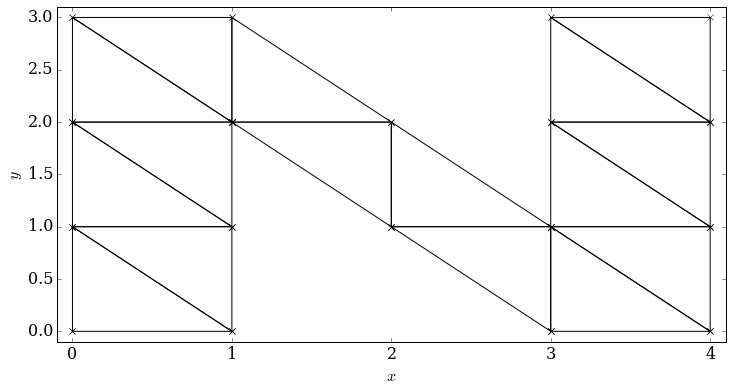

In [17]:
fig=pyplot.figure()
ax=fig.add_subplot(111)
for e in IEN_1m:
    coords = np.vstack((nodes_1m[e], nodes_1m[e[0]]))
    ax.plot(coords[:,0], coords[:,1],'kx-')
pyplot.xlim(-0.1,4.1)
pyplot.ylim(-0.1,3.1)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.show();

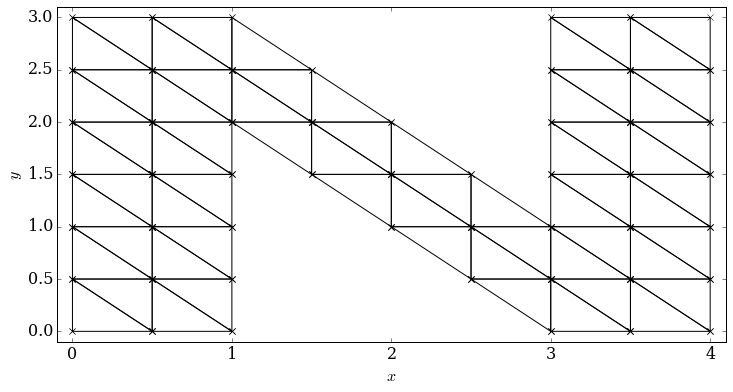

In [18]:
fig=pyplot.figure()
ax=fig.add_subplot(111)
for e in IEN_0_5m:
    coords = np.vstack((nodes_0_5m[e], nodes_0_5m[e[0]]))
    ax.plot(coords[:,0], coords[:,1],'kx-')
pyplot.xlim(-0.1,4.1)
pyplot.ylim(-0.1,3.1)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.show();

Compute the stiffness matrices

In [19]:
E = 4e10
nu = 0.15
K_1m = global_stiffness(E, nu, nodes_1m, IEN_1m, fixed_nodes_1m)
K_0_5m = global_stiffness(E, nu, nodes_0_5m, IEN_0_5m, fixed_nodes_0_5m)

Solve and plot the resulting displacement for the coarse mesh

In [20]:
F_1m = np.zeros(2*len(nodes_1m))
free_pos = np.hstack((2*free_nodes_1m, 2*free_nodes_1m + 1))
F_1m[free_pos] = 9.81*24000/len(nodes_1m)
F_1m[::2] = 0.0

d_1m = np.linalg.solve(K_1m, F_1m.T)

/home/kostas/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


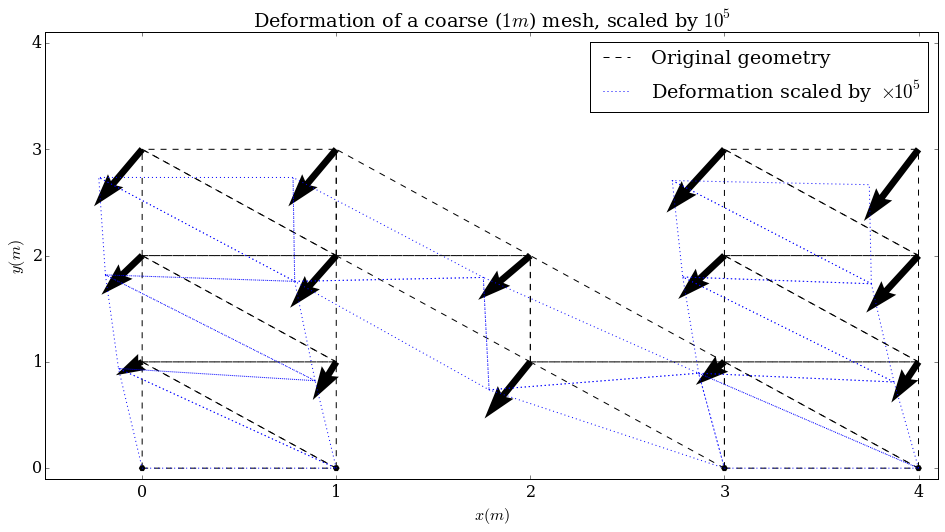

In [21]:
fig=pyplot.figure(figsize=(16,8))
ax=fig.add_subplot(111)
eps = d_1m.reshape(len(nodes_1m), 2) *1e5
cm = pyplot.cm.RdBu
for e in IEN_1m[:-1]:
    coords = np.vstack((nodes_1m[e], nodes_1m[e[0]]))
    coords_disp = np.vstack((nodes_1m[e] + eps[e], nodes_1m[e[0]] + eps[e[0]]))
    ax.plot(coords[:, 0], coords[:, 1], 'k--')
    ax.plot(coords_disp[:, 0], coords_disp[:, 1], 'b:')
e = IEN_1m[-1]
coords = np.vstack((nodes_1m[e], nodes_1m[e[0]]))
coords_disp = np.vstack((nodes_1m[e] + eps[e], nodes_1m[e[0]] + eps[e[0]]))
ax.plot(coords[:, 0], coords[:, 1], 'k--', label="Original geometry")
ax.plot(coords_disp[:, 0], coords_disp[:, 1], 'b:', label=r"Deformation scaled by $\times 10^5$")
ax.quiver(nodes_1m[:,0], nodes_1m[:,1], eps[:,0], eps[:, 1], label="Deformation direction$")
ax.set_xlim(-0.5, 4.1)
ax.set_ylim(-0.1, 4.1)
ax.set_xlabel(r"$x (m)$")
ax.set_ylabel(r"$y (m)$")
ax.set_title(r"Deformation of a coarse ($1m$) mesh, scaled by $10^5$")
ax.legend()

Solve and plot the resulting displacement for the fine mesh

In [22]:
F_0_5m = np.zeros(2*len(nodes_0_5m))
free_pos = np.hstack((2*free_nodes_0_5m, 2*free_nodes_0_5m + 1))
F_0_5m[free_pos] = 9.81*24000/len(nodes_0_5m)
F_0_5m[::2] = 0.0

d_0_5m = np.linalg.solve(K_0_5m, F_0_5m.T)

/home/kostas/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


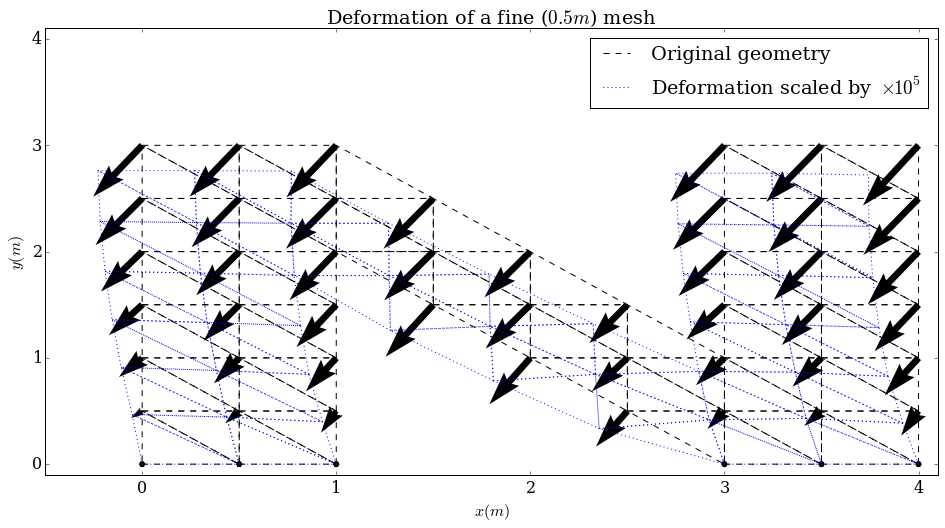

In [23]:
fig=pyplot.figure(figsize=(16,8))
ax=fig.add_subplot(111)
eps = d_0_5m.reshape(len(nodes_0_5m), 2) *1e5
for e in IEN_0_5m[:-1]:
    coords = np.vstack((nodes_0_5m[e], nodes_0_5m[e[0]]))
    coords_disp = np.vstack((nodes_0_5m[e] + eps[e], nodes_0_5m[e[0]] + eps[e[0]]))
    ax.plot(coords[:, 0], coords[:, 1], 'k--')
    ax.plot(coords_disp[:, 0], coords_disp[:, 1], 'b:')
e = IEN_0_5m[-1]
coords = np.vstack((nodes_0_5m[e], nodes_0_5m[e[0]]))
coords_disp = np.vstack((nodes_0_5m[e] + eps[e], nodes_0_5m[e[0]] + eps[e[0]]))
ax.plot(coords[:, 0], coords[:, 1], 'k--', label="Original geometry")
ax.plot(coords_disp[:, 0], coords_disp[:, 1], 'b:', label=r"Deformation scaled by $\times 10^5$")
ax.quiver(nodes_0_5m[:,0], nodes_0_5m[:,1], eps[:,0], eps[:, 1])
ax.set_xlim(-0.5, 4.1)
ax.set_ylim(-0.1, 4.1)
ax.set_xlabel(r"$x (m)$")
ax.set_ylabel(r"$y (m)$")
ax.set_title(r"Deformation of a fine ($0.5 m$) mesh")
ax.legend()

In [25]:
def test_suite():
    def test_Jacobian():
        return np.array_equal(Jacobian(np.arange(3)), np.array([2, 1]))
        
    def test_C():
        Ndims = 1
        C = np.zeros((Ndims,Ndims,Ndims,Ndims))
        Cfn = generate_constituitive_relation(1e5, 0.3)
        for i in range(Ndims):
            for j in range(Ndims):
                for k in range(Ndims):
                    for l in range(Ndims):
                        C[i,j,k,l] = Cfn(i,j,k,l)
        if abs(C[0,0,0,0] - 134615) < 1:
            return True
        else:
            return False
    
    def test_element():
        nodes = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
        Nnodes, Ndims = np.shape(nodes)
        C = np.zeros((Ndims,Ndims,Ndims,Ndims))
        Cfn = generate_constituitive_relation(1e5, 0.3)
        for i in range(Ndims):
            for j in range(Ndims):
                for k in range(Ndims):
                    for l in range(Ndims):
                        C[i,j,k,l] = Cfn(i,j,k,l)
        K = element_stiffness(nodes, C)
        
        return np.mean(K) < 1e-6
    
    def test_global_stiffness():
        nodes = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0]])
        IEN = [[0, 1, 2], [1, 2, 3]]
        
    if test_Jacobian():
        print("Test 1 succcess: The Jacobian function works as expected")
    if test_C():
        print("Test 2 success: The contititutive eq. matrix can be created")
    if test_element():
        print("Test 3 success: The stiffness matrix can be succesfully created for 1 element")

In [26]:
test_suite()

Test 1 succcess: The Jacobian function works as expected
Test 2 success: The contititutive eq. matrix can be created
Test 3 success: The stiffness matrix can be succesfully created for 1 element


In [34]:
nodes = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0]])
IEN = np.array([[0, 1, 2], [1, 2, 3]])
fixed_nodes = np.array([0, 1])

/home/kostas/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


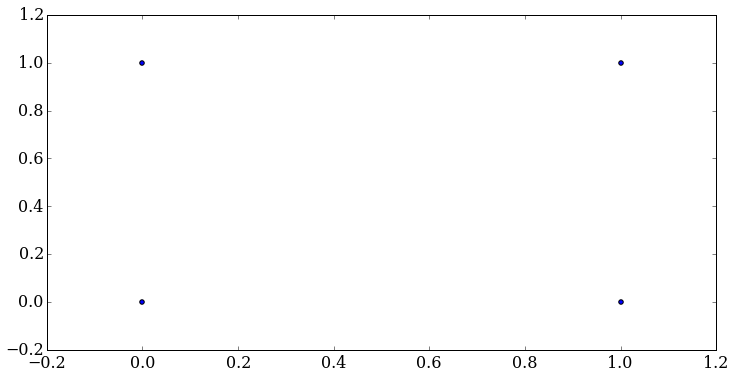

In [35]:
pyplot.scatter(nodes[:,0], nodes[:, 1])
E = 4e10
nu = 0.15
K = global_stiffness(E, nu, nodes, IEN, fixed_nodes)